In [ ]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 📈 Marketing Analytics with BigQuery and BQML

# BigQuery Guide For Marketing Analytics
<table align = "left">
<td>
<a href = "https://colab.sandbox.google.com/drive/1E4AuejqhhQlBHj3Xc9WEKw2J9KZVRx6r#scrollTo=0jeNfDdWLhsW">
<img src = "https://raw.githubusercontent.com/googleapis/python-bigquery-dataframes/refs/heads/main/third_party/logo/colab-logo.png" alt="Colab logo"> Run in Colab </a>
</td>

<td>
<a href = "https://colab.sandbox.google.com/drive/1E4AuejqhhQlBHj3Xc9WEKw2J9KZVRx6r#scrollTo=0jeNfDdWLhsW">
<img src = "https://raw.githubusercontent.com/googleapis/python-bigquery-dataframes/refs/heads/main/third_party/logo/github-logo.png" alt="GitHub logo"> View on GitHub </a>
</td>

<td>
<a href = "https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=">
<img src = "https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"> Open in Vertex AI Workbench </a>
</td>

<td>
<a href = "https://console.cloud.google.com/bigquery/import?url=">
<img src = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTW1gvOovVlbZAIZylUtf5Iu8-693qS1w5NJw&s" alt="BigQuery Studio logo" width = 32 > Open in BigQuery Studio </a>
</td>

</table>

|||
|-|-|
| Author(s) | [Paras Chavda] (https://github.com/paraschavda2411)

# An End-to-End Marketing Analytics and Forecasting with BigQuery

### Overview
### Overview
Stop just reporting on the past—start predicting the future. This notebook is your ultimate guide to unlocking the full power of your marketing data with Google BigQuery.

We'll cut through the noise of the raw Google Analytics 4 (GA4) dataset to uncover the insights that truly matter. But we won't stop there. You'll go hands-on with BigQuery ML to build a powerful model that predicts which customers are about to buy. Finally, we’ll use generative AI to instantly write the marketing emails to target them. This is the complete playbook for turning data into revenue, all within a single, powerful platform.

### **Dataset Overview**

We will be using the public GA4 ecommerce dataset. This dataset is a real-world, obfuscated log of user interactions from the Google Merchandise Store.

*   **Dataset Path in BigQuery:** `firebase-public-project.analytics_153293282.events_*`

I highly encourage you to open the Google Cloud Console, navigate to BigQuery, and explore this dataset yourself. You can inspect the full schema, preview the data, and get a feel for the richness of the information available before you begin.

### **Key Columns Reference**

The GA4 dataset has a nested structure. Here is a detailed description of the key fields we will be using for our analysis. We use dot notation (e.g., `traffic_source.source`) to access fields within a `RECORD`.

| Field Path (`column.nested_field`) | Data Type | Description |
| :--- | :--- | :--- |
| `event_date` | STRING | The date on which the event was logged (e.g., '20180801'). |
| `event_name` | STRING | The name of the event (e.g., 'purchase', 'view_item', 'session_start'). |
| `user_pseudo_id` | STRING | An anonymous identifier for a user/browser combination. |
| `traffic_source.source` | STRING | The source that drove the traffic (e.g., 'google', 'youtube.com'). |
| `traffic_source.medium`| STRING | The medium of the traffic (e.g., 'organic', 'cpc', 'referral'). |
| `traffic_source.name` | STRING | The name of the marketing campaign (e.g., 'data_studio_promo'). |
| `ecommerce.purchase_revenue_in_usd` | FLOAT | The total revenue from a purchase event, in USD. |
| `ecommerce.transaction_id` | STRING | The unique identifier for a transaction. |
| **`event_params`** | **REPEATED RECORD**| **An array containing parameters for the event. We will use this to find the session number.** |
| `event_params.key` | STRING | The name of the parameter (e.g., 'ga_session_number'). |
| `event_params.value.int_value` | INTEGER | The integer value of the parameter. |
| **`items`** | **REPEATED RECORD** | **An array of items associated with an event. Requires `UNNEST` to query.** |
| `items.item_name` | STRING | The name of the product. |
| `items.quantity` | INTEGER | The number of units of this specific item. |
| `items.item_revenue_in_usd` | FLOAT | The revenue generated by this specific item line (`price` * `quantity`). |



##### **Sections**:
1. **Setup & Authentication:** Configure the environment and authenticate with Google Cloud.
2. **Data Exploration:** Understand the structure and key fields of the GA4 dataset.
3. **Marketing KPI Analysis:** Calculate and visualize core marketing metrics.
    * Overall Sales Performance
    * Channel Performance
    * Product Performance
4. **AI-Powered Forecasting with BigQuery ML:**
    * Forecast future daily revenue.
    * Forecast future daily user traffic.

### 1. Setup & Authentication

First, we need to authenticate your Colab notebook to access your Google Cloud project and install the necessary Python libraries.

To begin, an analyst must have a Google Cloud project. The setup process is straightforward:

1. Create or Select a Project: Sign in to the Google Cloud Console. For this analysis, it is recommended to create a new, dedicated project. This practice ensures that all resources are isolated and can be easily cleaned up or deleted upon completion without affecting other work.
2. Enable Billing (Optional but Recommended): While BigQuery offers 1 TB free tier each month, which may already cover the analysis, enabling billing on the project is a prerequisite for moving beyond these limits.
3. Enable the BigQuery API: For new projects, the BigQuery API is typically enabled by default. However, if working with a pre-existing project, it is essential to verify that the API is active to ensure all functionalities are available.


In [ ]:
# Authentication
# Set your project ID
PROJECT_ID = "<PROJECT_ID>" # <--- CHANGE THIS
LOCATION = "US" # Located dataset and BQML models will be stored in this location

# Replace 'your-gcp-project-id' with the project you want to use for billing/quotas
!gcloud config set project $PROJECT_ID

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Updated property [core/project].
Authenticated


In [3]:
# Install Libraries & Set Project ID
# Make sure to change 'your-gcp-project-id' to your actual Google Cloud Project ID.
# This project will be used to run BigQuery jobs and store BQML models.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery

# Initialize BigQuery Client
bq_client = bigquery.Client(project=PROJECT_ID, location=LOCATION)

print(f"BigQuery client created for project: {PROJECT_ID}")

# Set some plotting styles for better visualizations
sns.set(style="whitegrid", rc={"figure.figsize": (12, 6)})


BigQuery client created for project: paras-sandbox-364712


### 2. Data Exploration

The GA4 data is event-based and has a nested structure. Let's run a quick query to understand the schema and the kind of data we are dealing with. We'll examine the events from a single day.

Please change the columns from data description above and have a look at the data before we went into next sections.

In [50]:
# You can use %%bigquery with project Id to directly run bigquery queries same
# as you do in console. We will see other ways of quering the data in
# this notebook in next sections.

%%bigquery --project $PROJECT_ID
SELECT
    event_date,
    event_name,
    user_pseudo_id,
    traffic_source.name AS campaign,
    traffic_source.medium AS medium,
    traffic_source.source AS source,
    ecommerce.transaction_id,
    ecommerce.purchase_revenue_in_usd
FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_20201101`
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,event_date,event_name,user_pseudo_id,campaign,medium,source,transaction_id,purchase_revenue_in_usd
0,20201101,page_view,1005694.5834348403,(organic),organic,google,None,NaN
1,20201101,first_visit,1005694.5834348403,(organic),organic,google,None,NaN
2,20201101,user_engagement,1005694.5834348403,(organic),organic,google,None,NaN
3,20201101,session_start,1005694.5834348403,(organic),organic,google,None,NaN
4,20201101,user_engagement,1013442.5000387623,(direct),(none),(direct),None,NaN
5,20201101,user_engagement,1013442.5000387623,(direct),(none),(direct),None,NaN
6,20201101,first_visit,1013442.5000387623,(direct),(none),(direct),None,NaN
7,20201101,page_view,1013442.5000387623,(direct),(none),(direct),None,NaN
8,20201101,page_view,1013442.5000387623,(direct),(none),(direct),None,NaN
9,20201101,session_start,1013442.5000387623,(direct),(none),(direct),None,NaN


### 3. Marketing KPI Analysis & Visualization

Now, let's compute and visualize some of the most important marketing KPIs.

#### 3.1 Overall Sales Performance: Daily Revenue


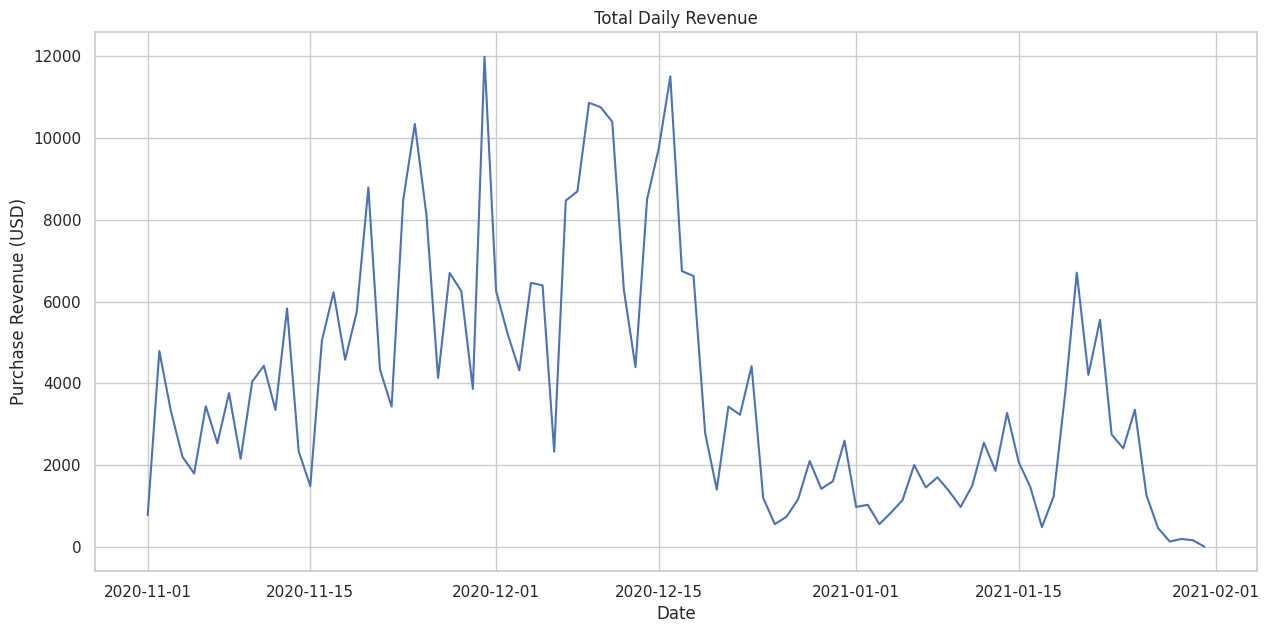

In [ ]:
# Query for Daily Revenue
# This uses traditional way of querying the BigQuery data and showing the plots.
daily_revenue_query = """
SELECT
    PARSE_DATE('%Y%m%d', event_date) AS date,
    SUM(ecommerce.purchase_revenue_in_usd) AS total_revenue
FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
WHERE
    event_name = 'purchase'
GROUP BY
    1
ORDER BY
    1
"""
df_daily_revenue = bq_client.query(daily_revenue_query).to_dataframe()

# Plot the results
plt.figure(figsize=(15, 7))
sns.lineplot(data=df_daily_revenue, x='date', y='total_revenue')
plt.title('Total Daily Revenue')
plt.xlabel('Date')
plt.ylabel('Purchase Revenue (USD)')
plt.show()


#### 3.2 Channel Performance: Revenue by Traffic Source

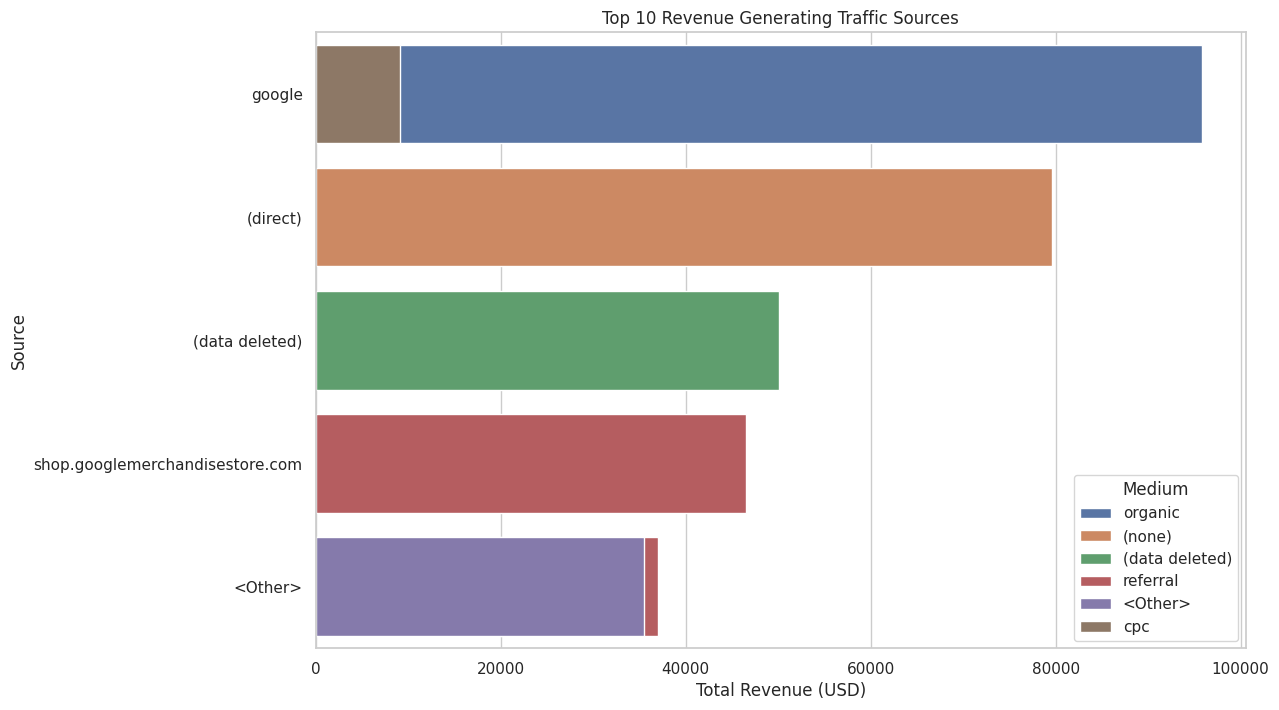

In [ ]:
# Query for Revenue by Channel
channel_revenue_query = """
SELECT
    traffic_source.source AS traffic_source,
    traffic_source.medium AS traffic_medium,
    SUM(ecommerce.purchase_revenue_in_usd) AS total_revenue
FROM
   `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
WHERE
    event_name = 'purchase'
GROUP BY
    1, 2
ORDER BY
    3 DESC
LIMIT 10
"""
df_channel_revenue = bq_client.query(channel_revenue_query).to_dataframe()

# Plot the results
plt.figure(figsize=(12, 8))
sns.barplot(data=df_channel_revenue, y='traffic_source', x='total_revenue', hue='traffic_medium', dodge=False)
plt.title('Top 10 Revenue Generating Traffic Sources')
plt.xlabel('Total Revenue (USD)')
plt.ylabel('Source')
plt.legend(title='Medium')
plt.show()


#### 3.3 Geographic Performance Analysis

This combination plot shows the total revenue from your top countries (bars) and overlays the average spend per user (line), allowing you to see if your largest markets are also your most valuable on a per-customer basis.


Running Geographic Performance query...


/tmp/ipython-input-3382914604.py:25: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df_geo = pd.read_gbq(geo_query, project_id=PROJECT_ID)


Data loaded successfully.
          country  total_revenue  unique_customers  average_revenue_per_user
0   United States       160573.0              1942                 82.684346
1           India        34986.0               406                 86.172414
2          Canada        32799.0               355                 92.391549
3  United Kingdom        11458.0               137                 83.635036
4           Spain         7681.0                84                 91.440476


/tmp/ipython-input-3382914604.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')


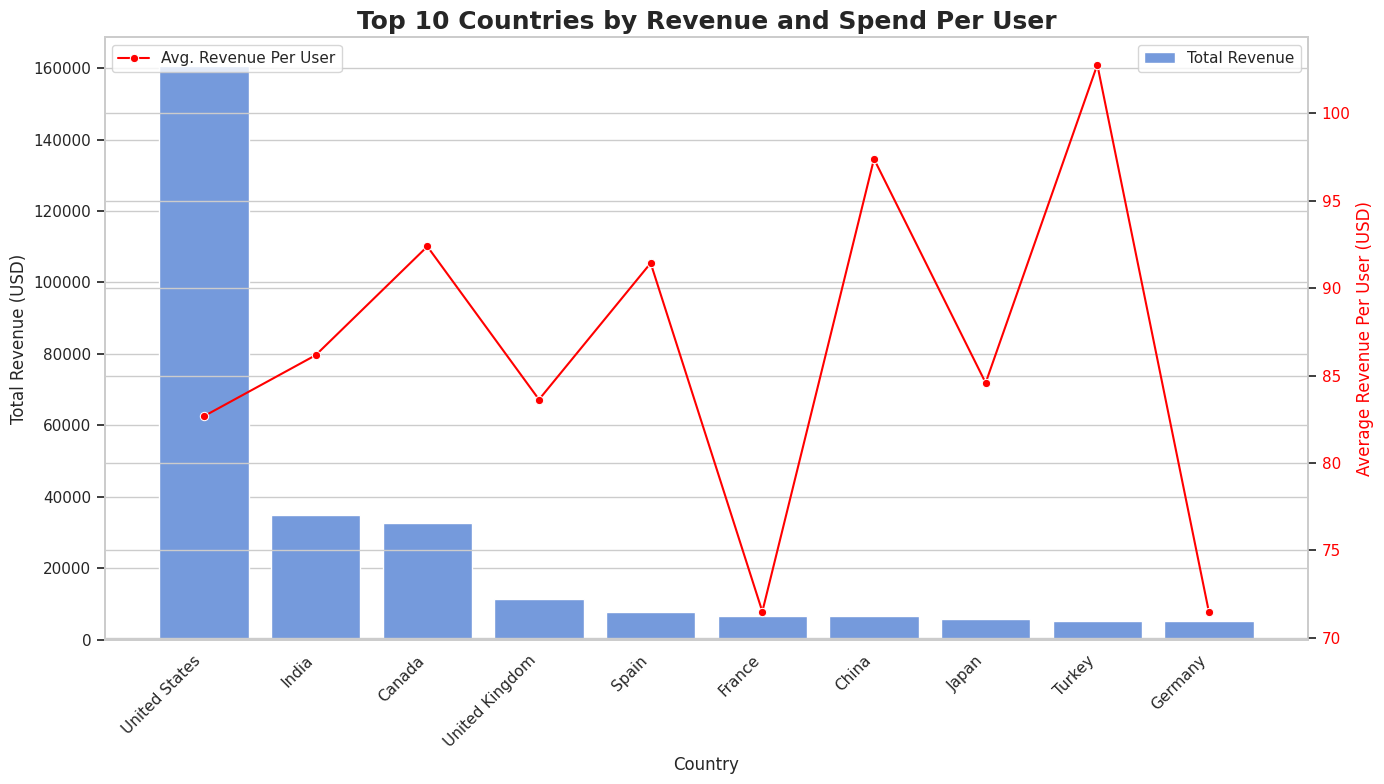

In [ ]:
# Geographic Performance Analysis
import pandas_gbq

# --- 1. Define the BigQuery Query ---
geo_query = """
SELECT
  geo.country,
  SUM(ecommerce.purchase_revenue_in_usd) AS total_revenue,
  COUNT(DISTINCT user_pseudo_id) AS unique_customers,
  SAFE_DIVIDE(SUM(ecommerce.purchase_revenue_in_usd), COUNT(DISTINCT user_pseudo_id)) AS average_revenue_per_user
FROM
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
WHERE
  event_name = 'purchase'
  AND geo.country IS NOT NULL
  AND geo.country != '(not set)'
GROUP BY
  geo.country
ORDER BY
  total_revenue DESC
LIMIT 10;
"""

# --- 2. Execute and Load into DataFrame ---
print("Running Geographic Performance query...")
df_geo = pandas_gbq.read_gbq(geo_query, project_id=PROJECT_ID)
print("Data loaded successfully.")
print(df_geo.head())

# --- 3. Create the Visualization ---
fig, ax1 = plt.subplots(figsize=(14, 8))
sns.set_style("whitegrid")

# Plotting Total Revenue as bars on the primary y-axis
sns.barplot(data=df_geo, x='country', y='total_revenue', ax=ax1, color='cornflowerblue', label='Total Revenue')
ax1.set_xlabel('Country', fontsize=12)
ax1.set_ylabel('Total Revenue (USD)', fontsize=12)
ax1.tick_params(axis='y')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')

# Creating a secondary y-axis for Average Revenue Per User
ax2 = ax1.twinx()
sns.lineplot(data=df_geo, x='country', y='average_revenue_per_user', ax=ax2, color='red', marker='o', label='Avg. Revenue Per User')
ax2.set_ylabel('Average Revenue Per User (USD)', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Top 10 Countries by Revenue and Spend Per User', fontsize=18, weight='bold')
fig.tight_layout()
plt.show()

#### 3.4 User Acquisition Analysis: New vs. Returning Users

Understanding the mix of new vs. returning customers is fundamental. Are we acquiring new customers or retaining existing ones?

Running query on BigQuery...
Downloading: 100%|██████████|
Data successfully loaded into DataFrame:
        user_type  distinct_users  total_revenue  average_revenue_per_user
0  Returning User            2736       240497.0                 87.900950
1        New User            1780       121668.0                 68.352809


/tmp/ipython-input-3761458544.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(
/tmp/ipython-input-3761458544.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(


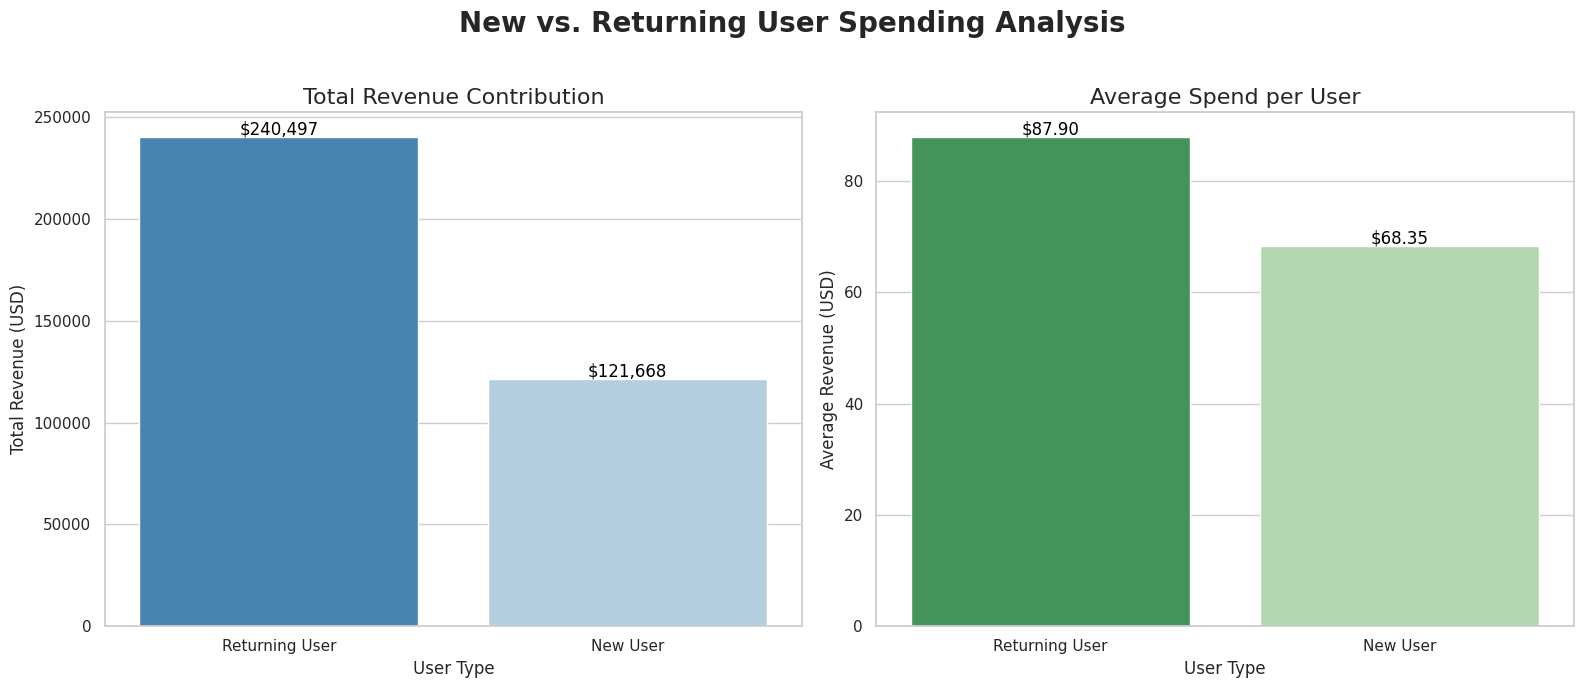

In [ ]:
# Query to classify New vs. Returning users and their spending
import seaborn as sns
import textwrap
import pandas_gbq

sql_query = """
WITH PurchaseEventsWithSessionNumber AS (
  SELECT
    t.user_pseudo_id,
    t.ecommerce.purchase_revenue_in_usd,
    params.value.int_value AS session_number
  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` AS t,
    UNNEST(event_params) AS params
  WHERE
    t.event_name = 'purchase'
    AND params.key = 'ga_session_number'
)
SELECT
  CASE
    WHEN session_number = 1 THEN 'New User'
    ELSE 'Returning User'
  END AS user_type,
  COUNT(DISTINCT user_pseudo_id) AS distinct_users,
  SUM(purchase_revenue_in_usd) AS total_revenue,
  SAFE_DIVIDE(SUM(purchase_revenue_in_usd), COUNT(DISTINCT user_pseudo_id)) AS average_revenue_per_user
FROM
  PurchaseEventsWithSessionNumber
GROUP BY
  user_type
"""

# Execute the query and load into a Pandas DataFrame
# This runs the query on BigQuery and brings the small result table into your notebook
print("Running query on BigQuery...")
df_user_kpis = pandas_gbq.read_gbq(sql_query, project_id=PROJECT_ID)
print("Data successfully loaded into DataFrame:")
print(df_user_kpis)


# Create the visualization
# Set the plot style
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# --- Plot 1: Total Revenue by User Type ---
ax1 = sns.barplot(
    data=df_user_kpis,
    x='user_type',
    y='total_revenue',
    ax=axes[0],
    palette='Blues_r'
)
ax1.set_title('Total Revenue Contribution', fontsize=16)
ax1.set_xlabel('User Type', fontsize=12)
ax1.set_ylabel('Total Revenue (USD)', fontsize=12)

# Add data labels
for p in ax1.patches:
    ax1.annotate(f'${p.get_height():,.0f}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 fontsize=12, color='black',
                 xytext=(0, 5),
                 textcoords='offset points')

# --- Plot 2: Average Revenue per User ---
ax2 = sns.barplot(
    data=df_user_kpis,
    x='user_type',
    y='average_revenue_per_user',
    ax=axes[1],
    palette='Greens_r'
)
ax2.set_title('Average Spend per User', fontsize=16)
ax2.set_xlabel('User Type', fontsize=12)
ax2.set_ylabel('Average Revenue (USD)', fontsize=12)

# Add data labels
for p in ax2.patches:
    ax2.annotate(f'${p.get_height():,.2f}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 fontsize=12, color='black',
                 xytext=(0, 5),
                 textcoords='offset points')

# --- Final Touches ---
fig.suptitle('New vs. Returning User Spending Analysis', fontsize=20, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for the suptitle
plt.show()


#### 3.5 Funnel Conversion Rate: Add-to-Cart to Purchase

How many users who add an item to their cart actually complete the purchase? This is a critical funnel metric.


Users who added to cart: 12545
Users who purchased: 4419
Add-to-Cart to Purchase Conversion Rate: 35.23%


/tmp/ipython-input-2839584026.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_funnel.index, y=df_funnel['unique_users'], palette='magma')


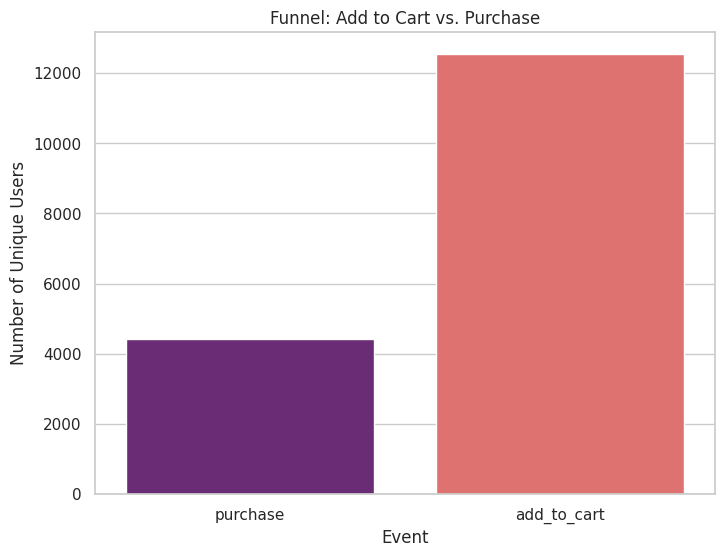

In [ ]:
funnel_query = """
SELECT
    event_name,
    COUNT(DISTINCT user_pseudo_id) AS unique_users
FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
WHERE
    event_name IN ('add_to_cart', 'purchase')
GROUP BY 1
"""
df_funnel = bq_client.query(funnel_query).to_dataframe().set_index('event_name')

# Calculate conversion rate
try:
    add_to_cart_users = df_funnel.loc['add_to_cart']['unique_users']
    purchase_users = df_funnel.loc['purchase']['unique_users']
    conversion_rate = (purchase_users / add_to_cart_users) * 100
except KeyError:
    conversion_rate = 0

print(f"Users who added to cart: {add_to_cart_users}")
print(f"Users who purchased: {purchase_users}")
print(f"Add-to-Cart to Purchase Conversion Rate: {conversion_rate:.2f}%")

# Plot the funnel
plt.figure(figsize=(8, 6))
sns.barplot(x=df_funnel.index, y=df_funnel['unique_users'], palette='magma')
plt.title('Funnel: Add to Cart vs. Purchase')
plt.ylabel('Number of Unique Users')
plt.xlabel('Event')
plt.show()


### 3. AI-Powered Forecasting with BigQuery ML

Now we'll use BQML to create a time-series model to forecast future revenue. This allows us to predict future trends directly within BigQuery using SQL.


#### The BigQuery ML Advantage

*   **No Data Movement:** We train the model where the data lives. This is faster, more secure, and less complex than exporting data to a Python environment.
*   **SQL-Based Workflow:** Data analysts and engineers who are proficient in SQL can build production-ready ML models without needing to be expert Python programmers.
*   **Scalability:** BigQuery handles the underlying infrastructure, allowing you to train models on terabytes of data with the same simple SQL commands.
*   **Integrated Lifecycle:** BQML provides SQL functions for training (`CREATE MODEL`), evaluation (`ML.EVALUATE`), and prediction (`ML.PREDICT`), creating a seamless workflow.

---


#### 3.1. Feature Engineering & Model Training (Single SQL Command)

This is the core of the BQML approach. We will write a single `CREATE MODEL` statement. This statement defines the features to be engineered, identifies the target variable, and tells BigQuery to train a classification model, all in one go.

We will use a `BOOSTED_TREE_CLASSIFIER`, which is BQML's equivalent of powerful algorithms like XGBoost and LightGBM.



In [ ]:
# Define and Run the BQML Training Job

# This single SQL statement does all the work:
# 1. Engineers the features from the raw event data.
# 2. Creates the target label (purchase in next 7 days).
# 3. Trains a boosted tree classification model.
# 4. Saves the trained model to your BigQuery project.

# Ensure the dataset for the model exists or else create one.
dataset_id = f"{PROJECT_ID}.marketing_analytics"
try:
    bq_client.get_dataset(dataset_id)
except Exception:
    bq_client.create_dataset(dataset_id)

# The BQML CREATE MODEL statement
bqml_train_query = f"""
CREATE OR REPLACE MODEL `{PROJECT_ID}.marketing_analytics.purchase_propensity_model`
OPTIONS(
  MODEL_TYPE='BOOSTED_TREE_CLASSIFIER',
  INPUT_LABEL_COLS=['label'],
  ENABLE_GLOBAL_EXPLAIN=TRUE -- For feature importance
) AS

-- The rest of the query is our feature engineering logic
WITH
  TrainingData AS (
    -- Step 1: Create a snapshot of features for each user based on their activity
    -- in a defined training period (e.g., May and June 2018).
    SELECT
    user_pseudo_id,
    -- Recency, Frequency, Monetary (RFM) Features
    DATE_DIFF(PARSE_DATE('%Y%m%d', '20210101'), PARSE_DATE('%Y%m%d', MAX(event_date)), DAY) as days_since_last_session,
    COUNT(DISTINCT(SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'ga_session_id')) AS session_count,
    IFNULL(SUM(ecommerce.purchase_revenue_in_usd), 0) AS total_revenue_so_far,

    -- Behavioral / Engagement Features
    COUNTIF(event_name = 'add_to_cart') AS add_to_cart_count,
    COUNTIF(event_name = 'view_item') AS product_views,
    COUNT(event_name) AS total_events

    FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
    WHERE
    -- Define the training period for feature creation
    _TABLE_SUFFIX BETWEEN '20201101' AND '20201231'
    GROUP BY
    user_pseudo_id
  ),
  FuturePurchases AS (
    -- Step 2: Create the label by identifying users who purchased in the 7 days
    -- immediately following our training period.
    SELECT DISTINCT
      user_pseudo_id
    FROM
      `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
    WHERE
      event_name = 'purchase'
      AND _TABLE_SUFFIX BETWEEN '20210101' AND '20210120' -- The prediction window
  )
-- Step 3: Join features with the label to create the final training set
SELECT
  td.*,
  -- If the user exists in FuturePurchases, their label is 1, otherwise 0.
  IF(fp.user_pseudo_id IS NOT NULL, 1, 0) AS label
FROM
  TrainingData td
LEFT JOIN
  FuturePurchases fp ON td.user_pseudo_id = fp.user_pseudo_id;
"""

print("Submitting BQML training job... This will take a few minutes.")
# Execute the query which starts the training job
training_job = bq_client.query(bqml_train_query)
# Wait for the job to complete
training_job.result()
print(f"Model `purchase_propensity_model` created successfully in dataset `{dataset_id}`.")


Submitting BQML training job... This will take a few minutes.
Model `purchase_propensity_model` created successfully in dataset `paras-sandbox-364712.marketing_analytics`.


#### 3.2. Model Evaluation with `ML.EVALUATE`

Now that the model is trained, we can use another simple SQL command to see how well it performed. `ML.EVALUATE` automatically calculates key classification metrics for us.



Evaluating model performance...
Downloading: 100%|██████████|
Evaluation metrics loaded.
   precision  recall  f1_score  accuracy   roc_auc
0        0.0     0.0       0.0  0.999206  0.828921
Downloading: 100%|██████████|


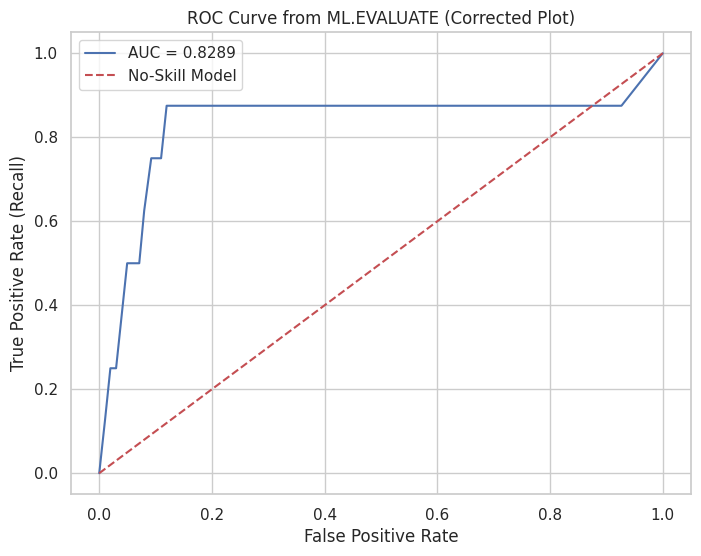

In [54]:
# Evaluate the Model's Performance
import pandas_gbq as pd

# This query retrieves the evaluation metrics for our trained model.
bqml_evaluate_query = f"""
SELECT
  *
FROM
  ML.EVALUATE(MODEL `{PROJECT_ID}.marketing_analytics.purchase_propensity_model`);
"""

print("Evaluating model performance...")
df_evaluation = pd.read_gbq(bqml_evaluate_query, project_id=PROJECT_ID)
print("Evaluation metrics loaded.")
print(df_evaluation[['precision', 'recall', 'f1_score', 'accuracy', 'roc_auc']].to_string())

# --- Plot the ROC Curve ---
roc_curve_query = f"""
SELECT
  *
FROM
  ML.ROC_CURVE(MODEL `{PROJECT_ID}.marketing_analytics.purchase_propensity_model`);
"""
df_roc = pd.read_gbq(roc_curve_query, project_id=PROJECT_ID)
df_roc = df_roc.sort_values(by='false_positive_rate')

plt.figure(figsize=(8, 6))
plt.plot(df_roc['false_positive_rate'], df_roc['recall'], label=f"AUC = {df_evaluation['roc_auc'][0]:.4f}")
plt.plot([0, 1], [0, 1], 'r--', label='No-Skill Model')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve from ML.EVALUATE (Corrected Plot)")
plt.legend()
plt.grid(True)
plt.show()


#### 3.3. Understanding the Model with `ML.FEATURE_INFO`

A key part of machine learning is interpretability. `ML.FEATURE_INFO` tells us which features our model found most important.


In [57]:
%%bigquery --project $PROJECT_ID
SELECT
  *
FROM
  ML.FEATURE_INFO(MODEL `marketing_analytics.purchase_propensity_model`);


Query is running:   0%|          |

Downloading:   0%|          |

,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,user_pseudo_id,NaN,NaN,NaN,NaN,NaN,169007,0,<NA>
1,days_since_last_session,1.0,61.0,29.168023,27.0,16.705662,<NA>,0,<NA>
2,session_count,1.0,12.0,1.349181,1.0,1.007332,<NA>,0,<NA>
3,total_revenue_so_far,0.0,1530.0,1.701853,0.0,20.332046,<NA>,0,<NA>
4,add_to_cart_count,0.0,98.0,0.241546,0.0,1.929926,<NA>,0,<NA>
5,product_views,0.0,330.0,1.667404,0.0,7.105213,<NA>,0,<NA>
6,total_events,1.0,1130.0,17.205654,5.0,42.557170,<NA>,0,<NA>


from matplotlib import pyplot as plt
_df_0['min'].plot(kind='hist', bins=20, title='min')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['max'].plot(kind='hist', bins=20, title='max')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['mean'].plot(kind='hist', bins=20, title='mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['median'].plot(kind='hist', bins=20, title='median')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('input').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='min', y='max', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='max', y='mean', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='mean', y='median', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='median', y='stddev', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9['min'].plot(kind='line', figsize=(8, 4), title='min')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['max'].plot(kind='line', figsize=(8, 4), title='max')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['mean'].plot(kind='line', figsize=(8, 4), title='mean')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['median'].plot(kind='line', figsize=(8, 4), title='median')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['input'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='min', y='input', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['input'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='max', y='input', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['input'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='mean', y='input', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['input'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='median', y='input', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

#### 3.4. Making Predictions with `ML.PREDICT`

Finally, we can use our trained model to make predictions on new data. We will use the same feature engineering logic but apply it to a different time period to simulate a real-world scenario.


In [58]:
# Make Predictions on New Data

# This query uses our trained model to predict which users are likely to
# purchase in the week following July 8th, based on their behavior up to that date.

bqml_predict_query = f"""
SELECT
  *
FROM
  ML.PREDICT(
    MODEL `{PROJECT_ID}.marketing_analytics.purchase_propensity_model`,
    (
      -- We use the same feature engineering query, just on a different date range
      SELECT
        user_pseudo_id,
        DATE_DIFF(PARSE_DATE('%Y%m%d', '20210201'), PARSE_DATE('%Y%m%d', MAX(event_date)), DAY) as days_since_last_session,
        COUNT(DISTINCT(SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'ga_session_id')) AS session_count,
        IFNULL(SUM(ecommerce.purchase_revenue_in_usd), 0) AS total_revenue_so_far,
        COUNTIF(event_name = 'add_to_cart') AS add_to_cart_count,
        COUNTIF(event_name = 'view_item') AS product_views,
        COUNT(event_name) AS total_events
      FROM
        `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
      WHERE
        -- Use a different, more recent time period for the features
        _TABLE_SUFFIX BETWEEN '20210120' AND '20210131'
      GROUP BY
        user_pseudo_id
    )
  )
WHERE
  -- Filter for users with a high probability of purchasing
  predicted_label_probs[OFFSET(1)].prob > 0.75
ORDER BY
  predicted_label_probs[OFFSET(1)].prob DESC
LIMIT 100;
"""

print("Making predictions on new user data...")
df_predictions = pd.read_gbq(bqml_predict_query, project_id=PROJECT_ID)
print("Top 100 users most likely to purchase:")
print(df_predictions[['user_pseudo_id', 'predicted_label']].head(10))



Making predictions on new user data...
Downloading: 100%|██████████|
Top 100 users most likely to purchase:
        user_pseudo_id  predicted_label
0  15166728.9687991470                0
1   5055352.2818270129                0
2  19131638.1831606785                0
3   4919352.4609342271                0
4  39279427.4735221133                0
5  61575965.0277712842                0
6  86694551.9723184524                0
7   4411122.9564325903                0
8  17200318.0084508263                0
9   8042272.4994438457                0


### 4. Conclusion & Key Learnings

This notebook demonstrated a powerful, end-to-end workflow for conducting marketing analytics and machine learning entirely within the Google Cloud ecosystem, centered around the capabilities of BigQuery.

#### Key Capabilities Demonstrated:

*   **Scalable Analytics:** We directly queried the raw, terabyte-scale GA4 dataset using standard SQL to aggregate and analyze complex, nested data structures with ease.
*   **Integrated Visualization:** We seamlessly moved aggregated data from BigQuery into Python (Pandas) to create rich, presentation-quality visualizations for a variety of critical KPIs (Geographic, Funnel, User Segments).
*   **End-to-End Machine Learning in SQL:** We built, trained, evaluated, and deployed a sophisticated purchase propensity model using BigQuery ML. This entire lifecycle was managed with just a few SQL commands, showcasing an incredibly efficient and accessible ML workflow.
*   **No Data Silos:** By keeping analytics and ML in the same platform, we eliminated the complexity, security risks, and latency associated with moving large datasets between different environments.

#### Strategic Business Value:

The insights and models generated here provide direct value to a marketing organization by enabling:
*   **Data-Driven Decision Making:** Moving from gut feelings to quantifiable metrics on channel performance, user behavior, and campaign effectiveness.
*   **Proactive Marketing:** The purchase propensity model allows the business to identify and target high-value users *before* they purchase, optimizing ad spend and personalizing outreach.
*   **Enhanced Efficiency:** The entire workflow, from raw data to a predictive model, is streamlined, allowing teams to generate value from their data faster than ever.

---


### 5. Bonus: Generative AI for Marketing Content Creation

Now that we have analytical insights (e.g., top products) and predictive insights (e.g., who is likely to buy), we can use BigQuery's new generative AI capabilities to turn these insights into action.

Let's use a BigQuery ML generative model (`gemini-pro`) to write a targeted marketing email based on our findings.


#### 5.1. Create a Connection and a Generative AI Model

First, you need to enable the Vertex AI API in your project. Then, you need a **Cloud Resource Connection** to allow BigQuery to use Vertex AI services.
1. Create one by going to BigQuery -> Add Data -> Vertex AI (Search for vertex AI)
2. Specify the CONNECTION_NAME that you are going to mention in next cell.
3. Once the connection is created, Click on Connection info -> Copy the Service account id
4. Give the service account `Vertex AI User` role through IAM.

For more information follow this [link](https://cloud.google.com/bigquery/docs/generate-text-tutorial-gemini#grant-permissions)

Once the above steps are completed, run the following SQL to create a BQML model that points to Google's Gemini Pro foundation model.

In [7]:
# Creating the GenAI model
# Note: You only need to run this cell once per project.
# Replace 'your-connection-name' with the name of the connection you just created.
CONNECTION_NAME = "gemini-marketing-analytics" # CHANGE THIS

create_genai_model_query = f"""
CREATE OR REPLACE MODEL `{PROJECT_ID}.marketing_analytics.gemini_pro_model`
  REMOTE WITH CONNECTION `projects/{PROJECT_ID}/locations/{LOCATION}/connections/{CONNECTION_NAME}`
  OPTIONS (endpoint = 'gemini-2.5-pro');
"""

print("Creating Generative AI model in BigQuery...")
genai_model_job = bq_client.query(create_genai_model_query)
genai_model_job.result()
print("Model `gemini_pro_model` created successfully.")


Creating Generative AI model in BigQuery...
Model `gemini_pro_model` created successfully.


#### 5.2. Generate Marketing Copy with `ML.GENERATE_TEXT`

Now, we will write a prompt that provides context from our analysis (e.g., a top product and a target audience segment) and ask the model to generate a compelling marketing email.


In [8]:
# This query feeds our analytical findings directly into a prompt for the Gemini Pro model.
generate_email_query = f"""
SELECT
  ml_generate_text_result
FROM
  ML.GENERATE_TEXT(
    MODEL `{PROJECT_ID}.marketing_analytics.gemini_pro_model`,
    (
      -- This is our prompt, crafted to use insights from our analysis
      SELECT
        CONCAT(
          'You are an expert marketing copywriter for the Google Merchandise Store. ',
          'Your task is to write a short, enthusiastic marketing email (under 100 words) to a user who we have identified as having a high probability of making a purchase soon. ',
          'The email should highlight one of our popular products. ',
          'Use the following information:\\n',
          ' - Target User Segment: Users who have recently been very active on our site and have added items to their cart.\\n',
          ' - Featured Product: "Google Rucksack"\\n',
          ' - Key Selling Point: It is a durable, stylish, and spacious backpack perfect for tech enthusiasts.\\n',
          'The email must have a clear subject line and a strong call-to-action.'
        ) AS prompt
    ),
    STRUCT(
      0.8 AS temperature,  -- Controls creativity
      1024 AS max_output_tokens,
      0.95 AS top_p,
      40 AS top_k
    )
  );
"""

print("Generating marketing email with Gemini Pro...")
df_generated_email = pd.read(generate_email_query, project_id=PROJECT_ID)
print("Email generated successfully!\n")

# -- Display the formatted email --
generated_text = df_generated_email['ml_generate_text_result'][0]
print("--- Generated Marketing Email ---")
print(generated_text)
print("---------------------------------")


Generating marketing email with Gemini Pro...


/tmp/ipython-input-2968072460.py:32: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df_generated_email = pd.read_gbq(generate_email_query, project_id=PROJECT_ID)


Email generated successfully!

--- Generated Marketing Email ---
{"candidates":[{"avg_logprobs":-4.948599094297828,"content":{"parts":[{"text":"Of course! Here is a short, enthusiastic marketing email crafted for a high-intent user.\n\n***\n\n**Subject:** Your Next Favorite Bag Is Waiting!\n\nHey there,\n\nWe saw you checking"}],"role":"model"},"finish_reason":"MAX_TOKENS","score":-202.89256286621094}],"create_time":"2025-09-25T06:40:52.169409Z","model_version":"gemini-2.5-pro","response_id":"9OPUaMGrCqyeqsMP2oyHwAI","usage_metadata":{"billable_prompt_usage":{"text_count":538},"candidates_token_count":41,"candidates_tokens_details":[{"modality":"TEXT","token_count":41}],"prompt_token_count":138,"prompt_tokens_details":[{"modality":"TEXT","token_count":138}],"thoughts_token_count":981,"total_token_count":1160,"traffic_type":"ON_DEMAND"}}
---------------------------------


### 6. Summary of Accomplishments & Potential Next Steps

This notebook has taken us on a complete journey from raw data to actionable, AI-driven marketing. By leveraging the integrated power of Google BigQuery, we have successfully demonstrated a modern, end-to-end analytics workflow.

#### What We Accomplished:

1.  **Established a Foundation with KPI Analysis:** We transformed raw, event-level GA4 data into high-level business intelligence. We calculated and visualized a wide array of crucial marketing KPIs, including sales trends, channel performance, geographic insights, and user segmentation (New vs. Returning), providing a comprehensive view of historical business performance.

2.  **Transitioned from Reporting to Prediction:** We moved beyond historical analysis by building a powerful **purchase propensity model** using BigQuery ML. With a single `CREATE MODEL` statement, we engineered features, trained the model, and evaluated its performance, demonstrating how to shift from a reactive to a proactive marketing stance by predicting future customer behavior.

3.  **Closed the Loop from Insight to Action with Generative AI:** We operationalized our predictive insights in the most direct way possible. By feeding the context of our analysis (target audience and product data) into a Gemini Pro model via `ML.GENERATE_TEXT`, we automatically created a personalized, ready-to-use marketing email, showcasing a complete, automated workflow from data to content.

In essence, we have demonstrated that BigQuery can serve as a single, unified platform for the entire data lifecycle: from large-scale analytics and BI to predictive machine learning and generative AI-powered activation.

#### Potential Next Steps:

The foundation we've built opens the door to even more advanced and impactful initiatives. Here are the logical next steps for a real-world implementation:

**1. Productionalize the Machine Learning Pipeline:**
*   **Automation:** Wrap the BQML training and prediction queries into a scheduled workflow using a tool like **Cloud Composer (Airflow)** or **Cloud Workflows**. This would allow you to automatically retrain the model and score new users on a daily or weekly basis.
*   **Integration:** Feed the list of high-propensity users generated by `ML.PREDICT` directly into marketing platforms like **Google Ads** (for building retargeting audiences) or a **CRM/Email platform** to trigger the automated sending of the generated emails.

**2. Enhance the Propensity Model:**
*   **Richer Feature Engineering:** Improve the model's accuracy by adding more sophisticated features. This could include time-based features (e.g., average time between sessions), ratio features (e.g., cart-to-view rate), and incorporating data from other sources like CRM or ad spend platforms.
*   **Hyperparameter Tuning:** Add the `ENABLE_HYPERPARAMETER_TUNING=TRUE` option to your `CREATE MODEL` statement to allow BigQuery to automatically find the optimal model settings, potentially squeezing out more predictive power.

**3. A/B Test the Generative AI Content:**
*   **Measure Effectiveness:** Use the `ML.GENERATE_TEXT` function to create several variations of the marketing email (e.g., different tones, subject lines, or calls-to-action).
*   **Run a Campaign:** Use a marketing automation tool to run an A/B test, sending different versions of the AI-generated email to segments of the high-propensity audience to scientifically measure which copy converts best.

**4. Build a Centralized BI Dashboard:**
*   **Democratize Insights:** Connect a Business Intelligence tool like **Looker** or **Looker Studio** directly to your BigQuery tables. Create an interactive dashboard that visualizes the KPIs from this notebook and tracks the performance of the propensity model over time, making these insights accessible to the entire marketing team.